Notebook to explore the effects of depth phases on global earthquake seismograms

In [11]:
import obspy
import numpy as np
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.taup import TauPyModel

In [2]:
client = Client("IRIS")
starttime = UTCDateTime("2000-01-01")
endtime = UTCDateTime("2024-01-01")

# Mariana Trench region bounds (approximate)
minlatitude = 10
maxlatitude = 25
minlongitude = 140
maxlongitude = 150

catalog = client.get_events(starttime=starttime, endtime=endtime,
                           minmagnitude=6,
                           minlatitude=minlatitude, maxlatitude=maxlatitude,
                           minlongitude=minlongitude, maxlongitude=maxlongitude)

print(f"Downloaded {len(catalog)} events from the Mariana Trench region.")

Downloaded 55 events from the Mariana Trench region.


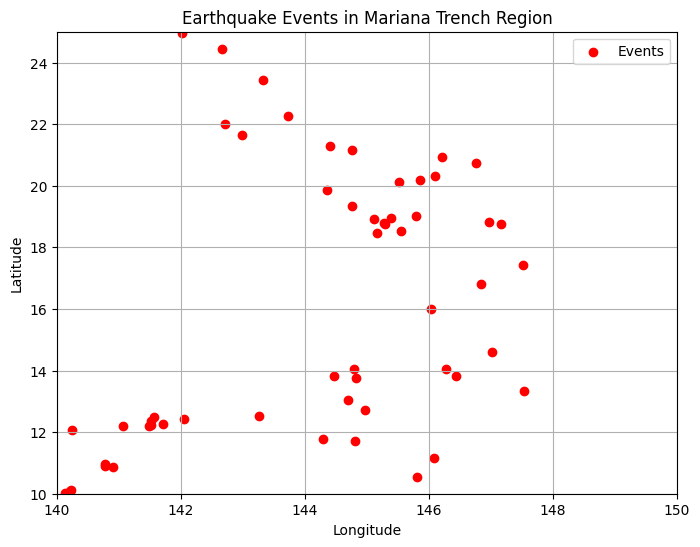

In [5]:
# Extract event coordinates
lats = [event.origins[0].latitude for event in catalog]
lons = [event.origins[0].longitude for event in catalog]

plt.figure(figsize=(8, 6))
plt.scatter(lons, lats, c='red', marker='o', label='Events')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Earthquake Events in Mariana Trench Region')
plt.xlim(minlongitude, maxlongitude)
plt.ylim(minlatitude, maxlatitude)
plt.legend()
plt.grid(True)
plt.show()

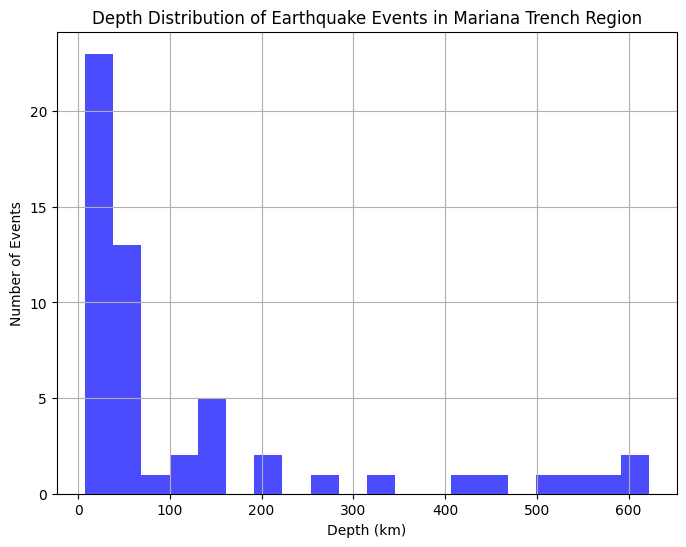

In [7]:
# plot the number of events as a function of depth
depths = [event.origins[0].depth / 1000.0 for event in catalog]  # convert to km
plt.figure(figsize=(8, 6))
plt.hist(depths, bins=20, color='blue', alpha=0.7)
plt.xlabel('Depth (km)')
plt.ylabel('Number of Events')
plt.title('Depth Distribution of Earthquake Events in Mariana Trench Region')
plt.grid(True)
plt.show()

In [20]:
# download the vertical seismogram for each event centered 20 seconds before the direct P arrival at station IU.ANMO
station = "IU.ANMO"
# get an invetngory for the station
inventory = client.get_stations(network="IU", station="ANMO", level="response")
# define model for tauP
model = obspy.taup.TauPyModel(model="iasp91")
seismograms = []
for event in catalog:
    origin_time = event.origins[0].time
    try:
        # for each event calculate the theoretical P arrival time at the station
        arrivals = model.get_travel_times(source_depth_in_km=event.origins[0].depth / 1000.0,
                                          distance_in_degree=obspy.geodetics.locations2degrees(
                                              event.origins[0].latitude,
                                              event.origins[0].longitude,
                                              inventory[0][0].latitude,
                                              inventory[0][0].longitude),
                                          phase_list=["P"])
        p_arrival = origin_time + arrivals[0].time
        print(p_arrival)
        # download seismogram from 20 seconds before P arrival to 300 seconds after origin time
        st = client.get_waveforms(network="IU", station="ANMO", location="00", channel="BHZ",
                                  starttime=p_arrival - 20,
                                  endtime=p_arrival + 3000)
        seismograms.append(st)
    except Exception as e:
        print(f"Could not download seismogram for event at {origin_time}: {e}")

2023-11-24T09:18:12.430123Z
2023-08-14T14:05:16.941208Z
Could not download seismogram for event at 2022-02-13T20:29:46.308000Z: list index out of range
Could not download seismogram for event at 2020-07-06T18:16:18.408000Z: list index out of range
2020-06-13T21:20:40.582296Z
2019-06-28T16:04:00.985603Z
2019-02-12T12:47:12.619728Z
2018-08-28T22:48:22.704437Z
2018-08-16T18:35:59.927187Z
2018-02-11T23:27:40.407101Z
Could not download seismogram for event at 2017-12-09T15:14:24.770000Z: list index out of range
Could not download seismogram for event at 2017-12-08T09:51:10.300000Z: list index out of range
Could not download seismogram for event at 2017-12-08T00:22:54.200000Z: list index out of range
2016-12-14T02:14:31.702197Z
2016-08-04T16:36:46.409048Z
2016-07-29T21:31:17.626009Z
2015-11-24T13:33:48.859274Z
2014-09-17T06:28:01.820687Z
2014-06-29T06:09:33.401385Z
2013-12-17T23:51:11.356756Z
2013-11-19T17:13:04.451972Z
Could not download seismogram for event at 2013-10-06T16:38:10.390000Z: 

1000.0
1000.0
1000.0
657.0081811798743
1000.0
855.5974933284559
891.5011343842979
1000.0
892.5010722318415
667.1844522397182
1000.0
1000.0
1000.0
1000.0
743.753802735122
1000.0
1000.0
997.7982297957614
902.0905355702819
829.9005268524038
806.1736408754414
1000.0
1000.0
793.7537461821663
1000.0
743.7300314282528
795.3584586347849
1000.0
857.2740493393657
822.1187766781544
1000.0
969.6448859011674
859.7377723157598
1000.0
1000.0
897.5856615412234
813.7478688139719
1000.0
1000.0


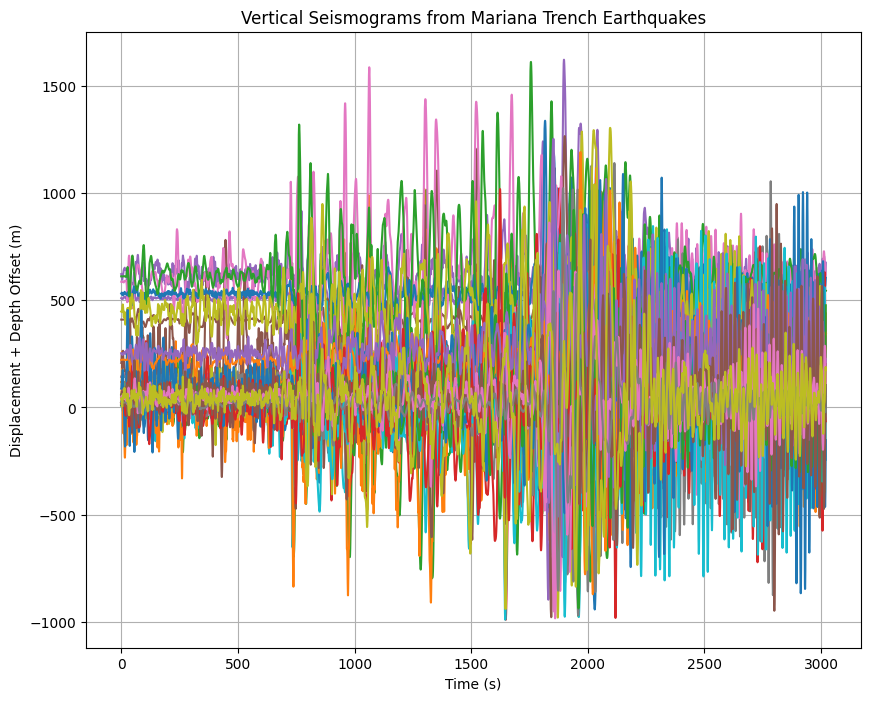

In [ ]:
# now plot the seismograms in displacement (so time integrated) as a function of the depth of the earthquake
plt.figure(figsize=(10, 8))
for i, st in enumerate(seismograms):
    depth = catalog[i].origins[0].depth / 1000.0  # in km
    tr = st[0]
    tr.detrend("linear")
    tr.detrend("demean")
    tr.filter("bandpass", freqmin=0.01, freqmax=10)
    tr.integrate()
    times = tr.times()
    # normalize the data for better visualization
    tr.data /= np.max(np.abs(tr.data))
    tr.data *= 1000

    plt.plot(times, tr.data + depth, label=f'Depth: {depth} km')  # offset by depth for visualization
plt.xlabel('Time (s)')
plt.ylabel('Displacement + Depth Offset (m)')
plt.title('Vertical Seismograms from Mariana Trench Earthquakes')
plt.grid(True)
plt.show()